In [1]:
%pip install --upgrade agrossuite

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
# import Agros Suite
from agrossuite import agros
from agrossuite.vtk_tools import view_geometry, view_scalar

In [19]:
L = 0.1
R1 = 0.01
R2 = 0.03
R3 = 0.05
R4 = 0.06
RB = 0.25
U = 10
eps1 = 3
eps2 = 4

### Agros Options

In [20]:
# Agros options

# enable stdout
agros.options.log_stdout = True

### Problem Class

In [21]:
# set problem and clear all fields
problem = agros.problem(clear = True)

# set coordinate system - valid keys: planar, axisymmetric
problem.coordinate_type = "axisymmetric"

# set mesh generator - valid keys: triangle, gmsh_quad (if installed)
problem.mesh_type = "triangle"

### Field Definition

In [22]:
# electrostatic
electrostatic = problem.field("electrostatic")
electrostatic.analysis_type = "steadystate"
electrostatic.number_of_refinements = 0
electrostatic.polynomial_order = 4
electrostatic.adaptivity_type = "disabled"
electrostatic.solver = "linear"

#### Boundaries

In [23]:
# boundaries
electrostatic.add_boundary("Source", "electrostatic_potential", {"electrostatic_potential" : U})
electrostatic.add_boundary("Ground", "electrostatic_potential", {"electrostatic_potential" : 0})
electrostatic.add_boundary("Neumann", "electrostatic_surface_charge_density", {"electrostatic_surface_charge_density" : 0})

#### Materials

In [24]:
# materials
electrostatic.add_material("Air", {"electrostatic_charge_density" : 0, "electrostatic_permittivity" : 1})
electrostatic.add_material("Dielectric 1", {"electrostatic_charge_density" : 0, "electrostatic_permittivity" : eps1})
electrostatic.add_material("Dielectric 2", {"electrostatic_charge_density" : 0, "electrostatic_permittivity" : eps2})

#### Geometry

In [25]:
# geometry
geometry = problem.geometry()

# edges
geometry.add_edge(0, RB, 0, L, boundaries = {"electrostatic" : "Neumann"})
geometry.add_edge(R1, L, R1, 0, boundaries = {"electrostatic" : "Source"})
geometry.add_edge(R1, 0, R2, 0, boundaries = {"electrostatic" : "Neumann"})
geometry.add_edge(R2, 0, R2, L)
geometry.add_edge(R2, L, R3, L)
geometry.add_edge(R3, 0, R2, 0, boundaries = {"electrostatic" : "Neumann"})
geometry.add_edge(R3, L, R3, 0, boundaries = {"electrostatic" : "Ground"})
geometry.add_edge(R4, 0, R4, L, boundaries = {"electrostatic" : "Ground"})
geometry.add_edge(R3, L, R4, L, boundaries = {"electrostatic" : "Ground"})
geometry.add_edge(R4, 0, RB, 0, boundaries = {"electrostatic" : "Neumann"})
geometry.add_edge(RB, 0, 0, RB, angle = 90, segments = 8, boundaries = {"electrostatic" : "Neumann"})
geometry.add_edge(R1, L, R2, L)
geometry.add_edge(R1, L, 0, L, boundaries = {"electrostatic" : "Source"})

# labels
geometry.add_label((R1+R2)/2.0, L/2.0, materials = {"electrostatic" : "Dielectric 1"})
geometry.add_label((R2+R3)/2.0, L/2.0, materials = {"electrostatic" : "Dielectric 2"})
geometry.add_label(R1, RB-R1, materials = {"electrostatic" : "Air"})

2

In [26]:
computation = problem.computation()
computation.solve()

Mesh Generator: Initial mesh generation
Mesh generator: Triangle
Mesh Generator: Reading initial mesh from memory
Solver: Solver - MUMPS (none)
Solver: Elapsed time: 00:00.016 s


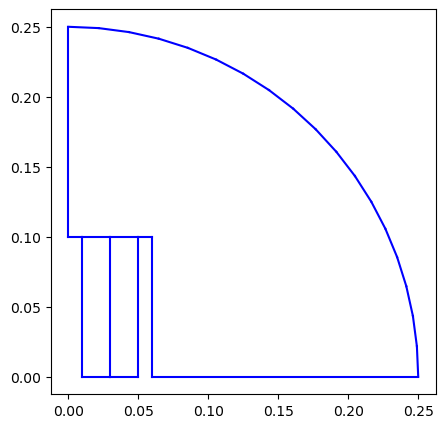

In [27]:
view_geometry(problem)

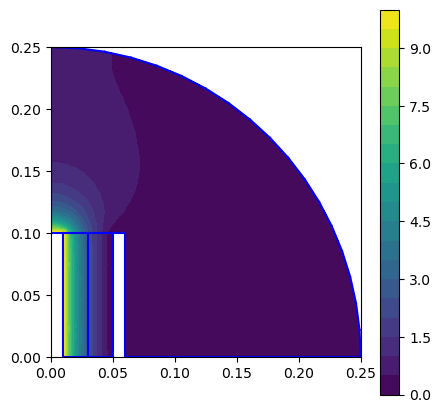

In [28]:
view_scalar(problem, computation, time_step=0, adaptive_step=0, field="electrostatic", variable="electrostatic_potential", component="scalar")

In [29]:
solution = computation.solution('electrostatic')

In [30]:
volume_integrals = solution.volume_integrals([0, 1, 2])
print(volume_integrals)

{'Ftx': -3.373452635171553e-08, 'Fty': 4.7649355946000485e-09, 'S': 0.047008570164780314, 'Tt': 0.0, 'V': 0.032269142630881355, 'We': 5.867719099749986e-10}


In [31]:
surface_integrals_1 = solution.surface_integrals([1, 12])
print(surface_integrals_1)

surface_integrals_2 = solution.surface_integrals([6, 7, 8])
print(surface_integrals_2)

{'Ftx': 0.0, 'Fty': 3.375085130050892e-08, 'Q': 1.1656938547097244e-10, 'S': 0.006597344572538565, 'Tm': 0.0, 'l': 0.10999999999999999}
{'Ftx': 0.0, 'Fty': -1.5362129470492977e-10, 'Q': -1.1679469543228947e-10, 'S': 0.07257079029792422, 'Tm': 0.0, 'l': 0.20999999999999996}


In [32]:
capacitance_volume = 2*volume_integrals['We']/(U**2)
print("capacitance_volume =    {} F".format(capacitance_volume))

capacitance_surface_1 = abs(surface_integrals_1['Q']/U)
print("capacitance_surface_1 = {} F".format(capacitance_surface_1))

capacitance_surface_2 = abs(surface_integrals_2['Q']/U)
print("capacitance_surface_2 = {} F".format(capacitance_surface_2))

capacitance_volume =    1.1735438199499972e-11 F
capacitance_surface_1 = 1.1656938547097244e-11 F
capacitance_surface_2 = 1.1679469543228946e-11 F


In [33]:
local_values = solution.local_values((R1+R2)/2, L/2)
print(local_values)

{'D': 8.968559878214266e-09, 'Dr': 8.968555851885997e-09, 'Dz': 8.498277244018354e-12, 'E': 337.6462569917275, 'Er': 337.64610540945705, 'Ez': 0.3199411657261635, 'V': 5.3180441035128405, 'epsr': 3.0, 'rho': 0.0, 'we': 1.5141003367426154e-06}
